# Basic kowledge about sentimental analysis
as the name suggest we use sentimental analysis to predict the emotions behind text, images or any form of given data 
we try to label a piece  of text as either positive or negative or neutral , we instance the sentiment in a scalar form.

# Dataset description and process explanation
my database is named as AllProductReviews which basically consists 5 main labels which represent the level of customer satisfaction  about n different products for better presentation I have sliced down the dataset for one of such products, but the tricky point here it doesn't contain any fixed sentiment , so in the code blocks below I have tried to determine the main sentiments through using the column named ReviewStar which is of int data type by using this label I have generated 5 unique sentiments(very bad , bad , average , good ,excellent) and perfomed onehotencoding for the binary transmission of the  sentiments. this is when the nltk and wordcloud packages come to picture, wordcloud helped me to present the top reviews of entire boat headphone reviews later on I have ntlk for processing the reviews and performed the GridSeearch using the random forest classifier. I have extracted the features using the countVectorizer and obtain the output score , accuracy score using the GridSearch with LogisticRegression and also visualize the top 100 words which resultesd in getting each of three sentiments i.e. average , excellent and bad.

In [126]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import precision_recall_curve,confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score
import nltk
nltk.download('wordnet')




[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
data = pd.read_csv(r"C:\Users\vijay\OneDrive\Desktop\AllProductReviews.csv")

In [65]:
data.head()
#data.size


,ReviewTitle,ReviewBody,ReviewStar,Product
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255


In [66]:
data['Product'].unique()

array(['boAt Rockerz 255', 'Flybot Wave', 'Flybot Boom', 'PTron Intunes',
       'Flybot Beat', 'Samsung EO-BG950CBEIN', 'JBL T205BT',
       'Sennheiser CX 6.0BT', 'Skullcandy S2PGHW-174', 'JBL T110BT'],
      dtype=object)

In [67]:
data['Review'] = data['ReviewTitle'] + data['ReviewBody']

# as the dataset offers reviews of various product I am scaling down the dataset to one product

In [69]:
boat = data[data['Product'] == "boAt Rockerz 255"]
x = boat['Review'] # saving it for future reference


In [70]:

boat.head()


,ReviewTitle,ReviewBody,ReviewStar,Product,Review
0,Honest review of an edm music lover\n,No doubt it has a great bass and to a great ex...,3,boAt Rockerz 255,Honest review of an edm music lover\nNo doubt ...
1,Unreliable earphones with high cost\n,"This earphones are unreliable, i bought it be...",1,boAt Rockerz 255,Unreliable earphones with high cost\nThis ear...
2,Really good and durable.\n,"i bought itfor 999,I purchased it second time,...",4,boAt Rockerz 255,"Really good and durable.\ni bought itfor 999,I..."
3,stopped working in just 14 days\n,Its sound quality is adorable. overall it was ...,1,boAt Rockerz 255,stopped working in just 14 days\nIts sound qua...
4,Just Awesome Wireless Headphone under 1000...😉\n,Its Awesome... Good sound quality & 8-9 hrs ba...,5,boAt Rockerz 255,Just Awesome Wireless Headphone under 1000...😉...


In [71]:
boat.drop(['ReviewTitle','ReviewBody'],inplace = True, axis = 1 ) 
# as we have combined column consisting both of these column data I am dropping them.

In [72]:
# removing the unnecessary content and special characters,from the Review column of the dataset boat 

In [73]:

boat['Review'] = boat['Review'].replace(r'https/S+','',regex = True)
# removing special characters like @,#,$
removeChar = str.maketrans('','','&@#%')
boat['Review'] = [x.translate(removeChar) for x in boat['Review']]
stpwords = set(STOPWORDS) # removing stop words 

In [74]:
def wordCloud(text):  # creating a function to foem a wordcloud virtualization
    wc = WordCloud(stopwords = stpwords,background_color = "white",width = 1000,height = 1000).generate(text)
    return wc

In [75]:
def plotWordCloud(wordCloud):
    plt.imshow(wordCloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.show()

In [76]:
words = " ".join(line.strip() for line in boat.Review)

These are the top words which provide us with sentiment


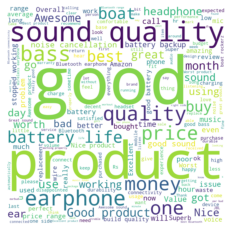

In [77]:
print("These are the top words which provide us with sentiment")
wordcloudAllContents = wordCloud(words)
plotWordCloud(wordcloudAllContents)

In [78]:
# object for WordNetLemmatizer
lm=WordNetLemmatizer()

In [79]:
def text_transformation(df_col):
    corpus=[]
    for item in df_col:
        new_item= re.sub('[^a-zA-Z]',' ',str(item))
        new_item= new_item.lower()
        new_item=new_item.split()
        new_item=[lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [80]:
corpus=text_transformation(boat['Review'])


In [81]:
cv=CountVectorizer(ngram_range=(1,2))
traindata=cv.fit_transform(corpus)
X=traindata
y=boat.ReviewStar

In [82]:
parameters={'max_features':('auto','sqrt'),
            'n_estimators':[5,10],
            'max_depth':[10,None],
            'min_samples_split':[5],
            'min_samples_leaf':[1],
            'bootstrap':[True]
    
}

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
grid_search= GridSearchCV(RandomForestClassifier(), parameters, cv=5, return_train_score=True, n_jobs=1)
grid_search.fit(X,y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [84]:
for i in range(8):
    print('Parameters: ', grid_search.cv_results_['params'][i])
    print('Mean test score:', grid_search.cv_results_['mean_test_score'][i])
    print('Rank', grid_search.cv_results_['rank_test_score'])

Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean test score: 0.42679999999999996
Rank [8 6 7 5 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean test score: 0.43099999999999994
Rank [8 6 7 5 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean test score: 0.42799999999999994
Rank [8 6 7 5 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean test score: 0.43600000000000005
Rank [8 6 7 5 4 2 3 1]
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean test score: 0.5025999999999999
Rank [8 6 7 5 4 2 3 

In [85]:
# as we have many complex comments we are trying to scale down to basic sentiments by using the review Star column 

In [86]:
# we have 5 sentiments we now try to bring it to more standard form  by using our own encoder

In [87]:
# determining my own sentiment column for analysis by using the ReviewStar column.
boat.loc[boat['ReviewStar'] == 1 , "Review" ] = "very bad"
boat.loc[boat['ReviewStar'] == 2, "Review"] = "bad"
boat.loc[boat['ReviewStar'] == 3, "Review"] = "average"
boat.loc[boat['ReviewStar'] == 4, "Review"] = "good"
boat.loc[boat['ReviewStar'] == 5, "Review"] = "excellent"

In [88]:
onehot = pd.get_dummies(boat['Review'])
boat = boat.join(onehot)


In [89]:
boat['org_review'] = x # I  have reassigned the orginal reviews for finding the wordFrequency of each sentiment

In [90]:
stop_words = stopwords.words('english')
countVect = CountVectorizer(binary=False, stop_words=stop_words,
                             token_pattern="[a-zA-Z]{2,}",#only considering words which have 2 alphabets in minimum
                             min_df=6,max_df=0.95)
features = countVect.fit_transform(boat.org_review)
allFeatures = countVect.get_feature_names()

In [91]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(features,boat.average , test_size=0.1, random_state=6)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features,boat.excellent , test_size=0.1, random_state=6)
X_train3, X_test3, y_train3, y_test3 = train_test_split(features,boat['very bad'], test_size=0.1, random_state=6)


In [92]:
from sklearn.linear_model import LogisticRegression
def model(X_train,y_train):
    params = {
        'C':[0.07,0.09,0.1,0.2,0.3,0.5,1]
    }

    logisticModel = LogisticRegression(random_state=6,verbose=0,n_jobs=-1,class_weight='balanced')
    gridSearch = GridSearchCV(logisticModel,params,verbose=3,n_jobs=-1)
    gridSearch.fit(X_train,y_train)

    return(gridSearch.best_estimator_)

In [93]:
modelNeutral = model(X_train1, y_train1)
print(modelNeutral)
pred = modelNeutral.predict(X_train1)
print("the accuracy score for  training average model is",accuracy_score(y_train1,pred))
# modelNeutral1 = model(X_test1,y_test1)
# prediction = modelNeutral.predict(X_test1)
# print("the accuracy score for testing average model is",accuracy_score(y_test1,pred))

Fitting 5 folds for each of 7 candidates, totalling 35 fits
LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=6)
the accuracy score for  training average model is 0.8851111111111111


<AxesSubplot:>

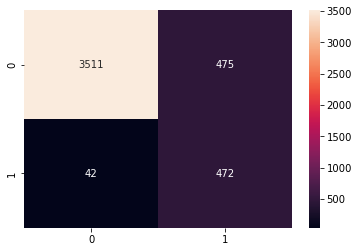

In [94]:
sns.heatmap(confusion_matrix(y_train1,pred),annot = True,fmt = 'g')

In [95]:
def wordCloudFromFrequency(dictionary):
    return WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).\
                                                generate_from_frequencies(dictionary)

# average scaled reviews

In [96]:
neutralEg = {}
indicesForNeutralEg = np.argsort(-1*modelNeutral.coef_)[:,0:100][0]
for i in indicesForNeutralEg[0:100]:
    neutralEg[allFeatures[i]] = modelNeutral.coef_[0,i]

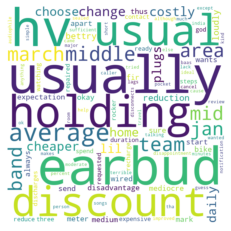

In [97]:
wordcloudNeutral = wordCloudFromFrequency(neutralEg)
plotWordCloud(wordcloudNeutral)

In [98]:
# as the above figure the above statement generally result in average satisfaction 

# top rated reviews 

In [99]:
modelExcellent = model(X_train2,y_train2)
print(modelExcellent)
pred = modelNeutral.predict(X_train2)
print("the accuracy score for  training average model is",accuracy_score(y_train2,pred))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
LogisticRegression(C=0.07, class_weight='balanced', n_jobs=-1, random_state=6)
the accuracy score for  training average model is 0.4391111111111111


In [100]:
ExcellentEg = {}
indicesForExcellentEg = np.argsort(-1*modelExcellent.coef_)[:,0:100][0]
for i in indicesForExcellentEg[0:100]:
    ExcellentEg[allFeatures[i]] = modelExcellent.coef_[0,i]

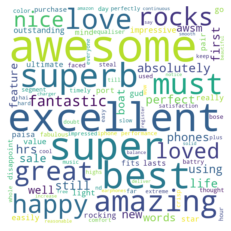

In [101]:
wordcloudExcellent = wordCloudFromFrequency(ExcellentEg)
plotWordCloud(wordcloudExcellent)

In [102]:
# the above statement shows us the excellent rated review words 

#  worst scaled reviews

In [103]:
modelBad = model(X_train3,y_train3)
print(modelBad)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
LogisticRegression(C=0.3, class_weight='balanced', n_jobs=-1, random_state=6)


In [104]:
BadEg = {}
indicesForBadEg = np.argsort(-1*modelBad.coef_)[:,0:100][0]
for i in indicesForBadEg[0:100]:
    BadEg[allFeatures[i]] = modelBad.coef_[0,i]

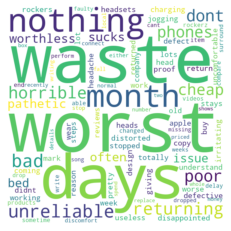

In [105]:
wordcloudBad= wordCloudFromFrequency(BadEg)
plotWordCloud(wordcloudBad)

In [106]:
# the above are the sentiment statements of bad reviewed or commented texts

# conclusion:  
by this project we are able  to predict the nature of the review and also identify the top 100 words of each sentiment


In [ ]:
# In  above code we have seen that we can know the sentiment by training the data but we cannot give dynamic input for the model 
# for this I have also tried to train another model which was explained by our mentor 
# In this model we train the model using the pre-existing model  , and also predict the nature of sentences (newly given)
# the data used in this model already has an label which represents the emotion , hence we encode the features ,apply vectorization
# perform classification using the gridSearchCV with RandomForestClassifier and its result helps us to decide the sentiment 
# we have sentiment_predictor method which analyzes and provides us sentiment by using the numerical outcome of classification. 

In [107]:
# another procedure of sentimental analysis 
train_df = pd.read_csv(r'train.txt',delimiter =";",names = ['text','label'])
val_df = pd.read_csv(r'var.txt',delimiter=";",names = ['text','label'] )

In [ ]:
in this process we will be able to check the sentiments

In [108]:
data = pd.concat([train_df,val_df])
data.reset_index(inplace = True,drop = True)
print("Shape of the dataframe ",data.shape)
data.sample(5)

Shape of the dataframe  (18000, 2)


,text,label
5167,i feel i can divine the future if only seconds...,joy
3315,i feel anxious for myself moment of truth i fe...,fear
16634,i found out in a nutshell at this time you are...,fear
17932,i feel for the author but i m also hesitant ov...,fear
9451,im still feeling terrible even though ive had ...,sadness


<AxesSubplot:xlabel='label', ylabel='count'>

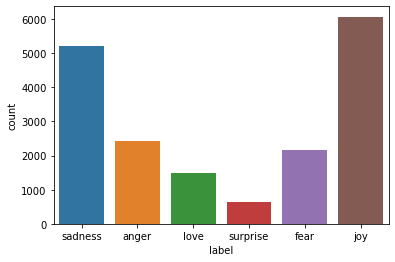

In [109]:
sns.countplot(data.label)

In [110]:
def custom_encoder(data):
    data.replace(to_replace="surprise", value=1, inplace=True)
    data.replace(to_replace="love", value=1, inplace=True)
    data.replace(to_replace="joy", value=1, inplace=True)
    data.replace(to_replace="fear", value=0, inplace=True)
    data.replace(to_replace="anger", value=0, inplace=True)
    data.replace(to_replace="sadness", value=0, inplace=True)

In [111]:
custom_encoder(data.label) 

In [112]:
lm=WordNetLemmatizer()

In [113]:
def text_transformation(df_col):
    corpus=[]
    for item in df_col:
        new_item= re.sub('[^a-zA-Z]',' ',str(item))
        new_item= new_item.lower()
        new_item=new_item.split()
        new_item=[lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [114]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
corpus=text_transformation(data['text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
cv=CountVectorizer(ngram_range=(1,2))
traindata=cv.fit_transform(corpus)
X=traindata
y=data.label

In [116]:
parameters={'max_features':('auto','sqrt'),
            'n_estimators':[5,10],
            'max_depth':[10,None],
            'min_samples_split':[5],
            'min_samples_leaf':[1],
            'bootstrap':[True]
    
}

In [117]:
grid_search= GridSearchCV(RandomForestClassifier(), parameters, cv=5, return_train_score=True, n_jobs=1)
grid_search.fit(X,y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [118]:
for i in range(8):
    print('Parameters: ', grid_search.cv_results_['params'][i])
    print('Mean test score:', grid_search.cv_results_['mean_test_score'][i])
    print('Rank', grid_search.cv_results_['rank_test_score'])

Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean test score: 0.601388888888889
Rank [7 5 8 6 3 1 4 2]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean test score: 0.6278888888888888
Rank [7 5 8 6 3 1 4 2]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean test score: 0.6005555555555556
Rank [7 5 8 6 3 1 4 2]
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
Mean test score: 0.6111111111111112
Rank [7 5 8 6 3 1 4 2]
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}
Mean test score: 0.9200555555555556
Rank [7 5 8 6 3 1 4 2]
Pa

In [119]:
rfc= RandomForestClassifier(max_features= grid_search.best_params_['max_features'],
                            max_depth= grid_search.best_params_['max_depth'],
                            n_estimators= grid_search.best_params_['n_estimators'],
                            min_samples_split=grid_search.best_params_['min_samples_split'],
                            min_samples_leaf= grid_search.best_params_['min_samples_leaf'],
                            bootstrap= grid_search.best_params_['bootstrap']
)

rfc.fit(X,y)

RandomForestClassifier(min_samples_split=5, n_estimators=10)

In [122]:
test = pd.read_csv(r'test.txt',delimiter = ";",names  = ['text','label'])

In [124]:
X_test, y_test= test.text, test.label

# encode the labels into two classes 0 and 1
test= custom_encoder(y_test)
# pre-processing of text
test_corpus=text_transformation(X_test)
# convert text data into vectors
testdata=cv.transform(test_corpus)
# predict the target
predictions=rfc.predict(testdata)

In [127]:
acc_score= accuracy_score(y_test, predictions)
pre_score= precision_score(y_test, predictions)
rec_score=recall_score(y_test, predictions)

print('Accuracy Score:', acc_score)
print('Precision Score:',pre_score)
print('Recall Score:',rec_score)
print("-"*50)
cr=classification_report(y_test, predictions)
print(cr)

Accuracy Score: 0.936
Precision Score: 0.9439461883408071
Recall Score: 0.9152173913043479
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1080
           1       0.94      0.92      0.93       920

    accuracy                           0.94      2000
   macro avg       0.94      0.93      0.94      2000
weighted avg       0.94      0.94      0.94      2000



<AxesSubplot:>

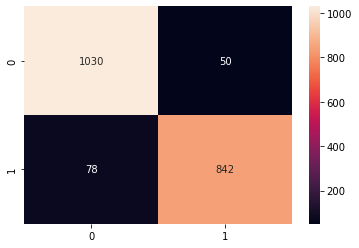

In [129]:
sns.heatmap(confusion_matrix(y_test,predictions),annot = True,fmt = 'g')

In [130]:
def expression_check(prediction_input):
    if prediction_input==0:
        print("Input statement has negative sentiment")
    elif prediction_input==1:
        print("input statement has positive sentiment")
    else:
        print("Invalid statement")

In [135]:
def sentiment_predictor(input):
    input=text_transformation(input)
    transofrmed_input=cv.transform(input)
    prediction= rfc.predict(transofrmed_input)
    expression_check(prediction)

In [140]:
ip1 = ['this is worst']
ip2 = ['this is bad']
sentiment_predictor(ip1)
sentiment_predictor(ip2)

Input statement has negative sentiment
Input statement has negative sentiment
